In [1]:
%matplotlib inline

In [351]:
import random
from typing import List, Tuple

import numpy as np
import torch
from torch import nn, optim
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

In [420]:
# Our code is generic enough to run both MNIST datasets.
# this flag decides which one to run.
fashion = True
if fashion:
    chosen_dataset = datasets.FashionMNIST
else:
    chosen_dataset = datasets.MNIST

In [434]:
def get_stats(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        # batch size (the last batch can have smaller size!)
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std


def get_loaders(batch_size):
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.28604069352149963,), (0.32045337557792664,)), # fash
        # transforms.Normalize((0.13066062331199646,), (0.301504522562027,)), # mnist
    ])

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.28604069352149963,), (0.32045337557792664,)), # fash
        # transforms.Normalize((0.13066062331199646,), (0.301504522562027,)), # mnist
    ])

    train_loader = torch.utils.data.DataLoader(
        dataset=chosen_dataset(
            root='../data', 
            train=True, 
            download=True,
            transform=train_transforms,
        ),
        batch_size=batch_size, 
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=chosen_dataset(
            root='../data', 
            train=False, 
            download=True,
            transform=test_transforms,
        ),
        batch_size=batch_size, 
        shuffle=False
    )
    return train_loader, test_loader

def train_epoch(
    model, 
    device, 
    train_loader, 
    optimizer, 
    criterion, 
    epoch, 
    log_interval
):
    model.train()
    history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))


def test(
    model, 
    device, 
    criterion, 
    test_loader
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            # get the index of the max log-probability
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss,
        correct,
        len(test_loader.dataset),
        accuracy
    ))
    return accuracy


def train(
    model,
    train_loader,
    test_loader,
    device,
    lr,
    nb_epochs=3,
    log_interval=100,
):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to(device)

    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)        
    
    return acc

def check_input(model, device):
    """
    Make sure the model outputs a correctly shaped tensor
    which is (batch_size, number_of_classes)
    """
    dummy_data = torch.zeros(5, 1, 28, 28).to(device)
    dummy_pred = model(dummy_data)
    error_message = (
        '\nOutput expected: (batch_size, 10)'
        f'\nOutput found   : {dummy_pred.shape}'
    )
    assert dummy_pred.shape == (5, 10), error_message
    print('Passed.')
    return dummy_pred

In [435]:
batch_size = 32
device_name = 'cuda'
nb_epochs = 3
log_interval = 500
lr = 1e-3

In [436]:
device = torch.device(device_name)
train_loader, test_loader = get_loaders(batch_size=batch_size)

In [437]:
print(
    'Train size: ', 
    train_loader.dataset.data.shape, 
    train_loader.dataset.targets.shape,
)
print(
    'Test size : ', 
    test_loader.dataset.data.shape, 
    test_loader.dataset.targets.shape,
)

Train size:  torch.Size([60000, 28, 28]) torch.Size([60000])
Test size :  torch.Size([10000, 28, 28]) torch.Size([10000])


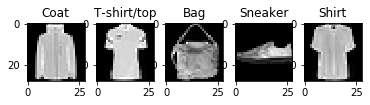

In [438]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
]
pics = random.sample(range(len(train_loader)), 5)
fig, axes = plt.subplots(1, 5)
for i, axis in zip(pics, axes):
    axis.imshow(train_loader.dataset.train_data[i], cmap='gray')
    title = train_loader.dataset.train_labels[i].item()
    if fashion:
        title = classes[title]
    axis.set_title(title)

In [439]:
instance: Tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))
print('Instance Example:', instance[0].shape, instance[1].shape)

Instance Example: torch.Size([32, 1, 28, 28]) torch.Size([32])


## Multilayer Perceptron

Three fully connected layers:
A layer 784 outputs (28 * 28, the size of the image),
a hidden layer with 350 outputs; roughly half the previous layer so we can start downsapling our "image",
and the final layer with 10 outputs that are our classes.

In [440]:
class MLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=784, out_features=784)
        self.lin2 = nn.Linear(in_features=784, out_features=350)
        self.fc = nn.Linear(in_features=350, out_features=10)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = x.view(x.shape[0], 28 * 28)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        out = self.fc(x)
        return out


mlpnet = MLPNet().to(device)
dummy_pred = check_input(mlpnet, device)
print(mlpnet)

Passed.
MLPNet(
  (lin1): Linear(in_features=784, out_features=784, bias=True)
  (lin2): Linear(in_features=784, out_features=350, bias=True)
  (fc): Linear(in_features=350, out_features=10, bias=True)
  (relu): ReLU(inplace)
)


In [442]:
acc = train(mlpnet, train_loader, test_loader, device, 1e-4, nb_epochs, log_interval)
print(f'Final acc: {acc:.2f}%')


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.321942
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.393759
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.191554
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.212495

* * * Evaluating * * *
Test set: Average loss: 0.0126, Accuracy: 8560/10000 (85.60%)


* * * Training * * *
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.445318
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.401945
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.546911
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.208726

* * * Evaluating * * *
Test set: Average loss: 0.0125, Accuracy: 8585/10000 (85.85%)


* * * Training * * *
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.402490
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.274388
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.229208
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.454045

* * * Evaluating * * *
Test set: Average loss: 0.0124, Accuracy: 8596/10000 (85.96%)

Final acc: 85.96%


### An Inception layer, but with fully connected layers.
Inspired by the now world-famous paper by Google employees (InceptionV1)[https://arxiv.org/pdf/1409.4842.pdf] that uses parallel convolutions to make better use of the immense parallelization capabilities GPUs provide to start growing neural networks girth-wise instead of only depth-wise, we created this LinearInception module.
We thought this would give our model a bigger receptive field and that that would give us a huge gain in accuracy, but we were wrong.

In [446]:
class LinearInception(nn.Module):
    def __init__(self, in_features, out_features, cardinality):
        super().__init__()
        self.card = cardinality
        self.fcs = nn.ModuleList([
            nn.Linear(in_features=in_features, out_features=out_features)
            for _ in range(cardinality)
        ])
        self.fc_aggregate = nn.Linear(
            in_features=out_features * cardinality,
            out_features=out_features
        )

    def forward(self, x):
        x = nn.parallel.parallel_apply(self.fcs, (x,) * self.card)
        x = torch.stack(x, dim=1)
        x = x.view(x.shape[0], -1)
        x = self.fc_aggregate(x)
        return x


class InceptionMLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=784, out_features=784)
        self.lin2 = LinearInception(in_features=784, out_features=350, cardinality=3)
        self.lin_end = nn.Linear(in_features=350, out_features=10)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = x.view(x.shape[0], 28 * 28)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.lin_end(x)
        return out

incmlp = InceptionMLPNet().to(device)
dummy_pred = check_input(incmlp, device)
print(incmlp)

Passed.
InceptionMLPNet(
  (lin1): Linear(in_features=784, out_features=784, bias=True)
  (lin2): LinearInception(
    (fcs): ModuleList(
      (0): Linear(in_features=784, out_features=350, bias=True)
      (1): Linear(in_features=784, out_features=350, bias=True)
      (2): Linear(in_features=784, out_features=350, bias=True)
    )
    (fc_aggregate): Linear(in_features=1050, out_features=350, bias=True)
  )
  (lin_end): Linear(in_features=350, out_features=10, bias=True)
  (relu): ReLU(inplace)
  (dropout): Dropout(p=0.1)
)


In [448]:
acc = train(incmlp, train_loader, test_loader, device, 1e-4, nb_epochs, log_interval)
print(f'Final acc: {acc:.2f}%')


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.450436
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.292167
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.424795
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.604289

* * * Evaluating * * *
Test set: Average loss: 0.0126, Accuracy: 8542/10000 (85.42%)


* * * Training * * *
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.613697
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.315931
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.192128
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.341053

* * * Evaluating * * *
Test set: Average loss: 0.0124, Accuracy: 8574/10000 (85.74%)


* * * Training * * *
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.190846
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.079334
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.363328
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.349266

* * * Evaluating * * *
Test set: Average loss: 0.0123, Accuracy: 8578/10000 (85.78%)

Final acc: 85.78%


## ConvNet só para não perder o costume.

Duas convs e uma fully connected layer no final para dizer minhas classes.
Depois de cada conv, uma relu para introduzir não-linearidade e um MaxPooling para reduzir o tamanho conforme a dimensionalidade aumenta.

In [443]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=3136, out_features=10)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], 64 * 7 * 7) # Ou x = x.view(x.shape[0], -1)
        out = self.fc(x)
        return out
    
convnet = ConvNet().to(device)
dummy_pred = check_input(convnet, device)
print(convnet)

Passed.
ConvNet(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=3136, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace)
)


In [445]:
acc = train(convnet, train_loader, test_loader, device, 1e-4, nb_epochs, log_interval)
print(f'Final acc: {acc:.2f}%')


* * * Training * * *
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.353777
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.151119
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.399603
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.368347

* * * Evaluating * * *
Test set: Average loss: 0.0105, Accuracy: 8813/10000 (88.13%)


* * * Training * * *
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.293477
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.235461
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.311738
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.206354

* * * Evaluating * * *
Test set: Average loss: 0.0106, Accuracy: 8808/10000 (88.08%)


* * * Training * * *
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.558048
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.381771
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.115153
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.386943

* * * Evaluating * * *
Test set: Average loss: 0.0104, Accuracy: 8841/10000 (88.41%)

Final acc: 88.41%


### Observações
Embora saibamos que MPLs são inapropriados para tarefas de imagem, porque cada neorônio fica atrelado a um pixel o que as não permite que o modelo se torne invariante a translações, redimensionamentos, etc., decidimos usá-los mesmo assim, pois os conjuntos de dados que escolhemos (MNIST e FashionMNIST) contêm apenas imagens bem centralizadas e de dimensões muito semelhantes entre si.

Nosso melhor resultado foi no MLP tradicional com learning rate de 0.001 por três epochs. Dividir a learning rate por 10 e treinar mais dois epochs conseguiu um ganho de aproximadamente 1% e é o que fizemos para todos modelos.

### State of the art
Estado da arte (sem deep learning) do dataset que escolhemos é 89.7% accuracy e o modelo usado é um SVC (roda em tempo quadrático em relação ao número de instâncias) e foi treinado por 1h12min (mais detalhes http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/), enquanto nossos modelos todos demoram menos de 1 minuto para serem treinados.

Estado da arte atual do dataset é do github user (@ajbrock)[https://github.com/ajbrock] com 96.7% de accuracy usando uma (wide residual network)[https://arxiv.org/pdf/1605.07146.pdf] de 40 camadas e largura 4 (8,9M paramêtros).

### Our results
Our data augmentation steps are just standard preprocessing (mean/std subtraction/division) and random horizontal flips.

Acc: 85.96% na MLPNet.  Hyperparams: 3 epochs 1e-3 + 3 epochs 1e-4.
Acc: 85.78% na IncMLP.  Hyperparams: 3 epochs 1e-3 + 3 epochs 1e-4.
Acc: 88.41% na ConvNet. Hyperparams: 3 epochs 1e-3 + 3 epochs 1e-4.

### Conclusão
Mais epochs só fizeram nosso modelo overfit, então provavelmente estamos no limite da capacidade desses modelos (ignorando possíveis estratégias de regularização).

A partir dos nossos testes empíricos, notamos que mesmo com modificações grandes, que supostamente deveriam tornar o modelo muito mais robusto, conseguimos pouquíssimos ganhos de accuracy.

Na nossa opinião, isso significa que estamos nos aproximando do ponto em que a derivada da curva de ganhos em relação a esforços é quase zero, o que significa que precisamos de muito, muito mais esforços (por exemplo o state of the art com quase 9 milhões de parâmetros e nossa MPLNet com 893700, ele precisou de 10 vezes mais parâmtetros e uma estrutura muito mais complicada para 9% de melhoria).